In [2]:
#import functions
import numpy as np
from numpy import linalg

import cv2 as cv
import scipy
from scipy import signal

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import shutil

from utils import resize_percent, edge_detect, count_gray_levels, fill
# from utils import show_image

In [1]:
#cross correlation function

def cross_correlation (frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=False):
    image_1_name = os.fsdecode(os.listdir(path_to_images)[0])
    image_1 = cv.imread(path_to_images + f'{image_1_name}', cv.IMREAD_GRAYSCALE)
    corr_full_x = np.zeros([image_1.shape[1], frNum])
    corr_full_y = np.zeros([image_1.shape[0], frNum])
    k=0
    while k<frNum:
        image_name = str(k) + '.jpg'
        image_next = cv.imread(path_to_images+f'{image_name}', cv.IMREAD_GRAYSCALE)
        if x_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[pixel[0], :], arr_1, mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[1],)) #normalization added
            corr_full_x[:, k] = corr
        if y_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[:, pixel[1]], np.transpose(arr_1), mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[0],)) #normalization added
            corr_full_y[:, k] = corr          
        k+=1
    
    return corr_full_x, corr_full_y

10
[[  1.           1.           1.         ... 240.87288136 232.1682243
  174.50515464]
 [  2.55487805   2.54545455   1.         ... 227.90677966 246.46728972
  190.27835052]
 [  8.77439024   5.63636364   1.         ... 206.29661017 256.
  206.05154639]
 ...
 [238.89634146 235.90909091 233.82608696 ... 251.6779661  248.85046729
  234.96907216]
 [242.00609756 237.45454545 233.82608696 ... 251.6779661  248.85046729
  237.59793814]
 [242.00609756 237.45454545 233.82608696 ... 253.83898305 248.85046729
  240.22680412]]


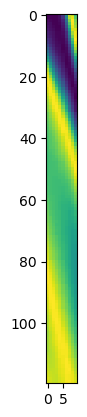

In [3]:
# implement slope measurement for one pixel
# 100x100 pixels
#iterate through each pixel to get a correlation result
frNum = 10
path_to_images = 'sim_2perc_crop/'
# path_to_images = 'sim_1perc_crop/'
# path_to_images = 'sim_05perc_crop/'
kernel = 1
threshold_bin = 0

pixel_x = 4
pixel_y = 0
pixel_array = []
for x in range(0, pixel_x + 1):
     for y in range(0, pixel_y + 1):
        pixel = [pixel_x, pixel_y]
pixel_array.append(pixel)         
         
#corr_full_y is 100x29 matrix which represents one pixel      
_, corr_full_y = cross_correlation(frNum, path_to_images, pixel_array[0], kernel, x_disp=False, y_disp=True)

plt.imshow(corr_full_y)
print(corr_full_y.shape[1])
print(corr_full_y)

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


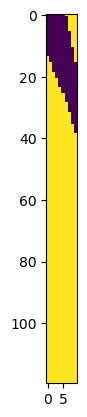

In [4]:
#clean version
T=120
image = np.copy(corr_full_y)
image[corr_full_y<T] = 0
image[corr_full_y>=T] = 1
plt.imshow(image)
print(image)

In [5]:
# Save the Numpy array as Image
image_filename = "image0_2perc.jpeg"
i=0
saved_image = plt.imsave(fname=image_filename, arr=image)

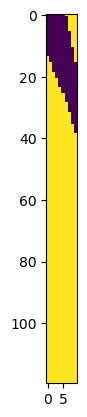

In [6]:
img = cv.imread(filename=image_filename, flags=cv.IMREAD_GRAYSCALE)
plt.imshow(image)
# print(image)

[[ 28  28  30 ... 178 209 214]
 [ 27  28  30 ... 170 207 214]
 [ 28  29  30 ... 162 205 214]
 ...
 [215 215 215 ... 215 215 215]
 [215 215 215 ... 215 215 215]
 [215 215 215 ... 215 215 215]]


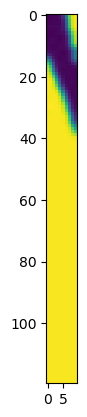

In [7]:
img_bl = cv.GaussianBlur(src=img, ksize=(7, 7), sigmaX=1)
plt.imshow(img_bl)
print(img_bl)
max_gray_level_img = count_gray_levels(img_bl)

[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


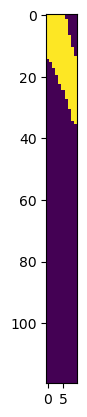

In [11]:
GRAY_LEVEL_01 = 100
img_th = cv.inRange(src=img_bl, lowerb=0, upperb=GRAY_LEVEL_01)
plt.imshow(img_th)
print(img_th)

[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


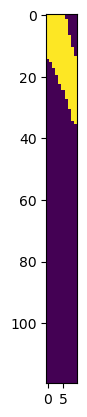

In [12]:
cnts = cv.findContours(img_th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv.contourArea, reverse=True)

# img_emb = np.zeros((img_th.shape), np.uint8)
img_emb = np.copy(img_th)
(x, y, w, h) = cv.boundingRect(cnts[0])
area_max = w*h
for c in cnts:
    (x, y, w, h) = cv.boundingRect(c)
    cnt_area = w*h
    if cnt_area < area_max:
        img_emb[y:y+h, x:x+w] = 0
plt.imshow(img_emb)
print(img_emb)

In [17]:
def find_connected_components(img):
    n_labels, labels, stats, centroids = cv.connectedComponentsWithStats(image=img.copy(), connectivity=8, ltype=cv.CV_32S)
    areas = stats[1:, cv.CC_STAT_AREA]
    return labels, areas

[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


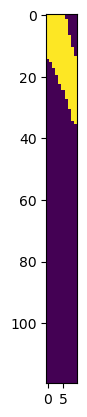

In [18]:
labels, areas = find_connected_components(img_th)
if len(areas) == 0:
    print("no area")
else:
    area_max_idx = np.argmax(areas)
img_emb= np.zeros(labels.shape, dtype=np.uint8)
img_emb[labels == area_max_idx + 1] = 255
plt.imshow(img_emb)
print(img_emb)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


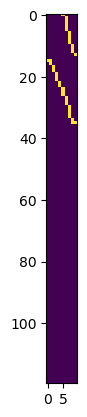

In [19]:
WHITE_LEVEL = 255
img_ed = cv.Canny(image=img_emb, threshold1=WHITE_LEVEL//2, threshold2=WHITE_LEVEL, apertureSize=3, L2gradient=True)
plt.imshow(img_ed)
print(img_ed)

[[ 0  0  0 ... 43  9  1]
 [ 0  0  0 ... 50 11  2]
 [ 0  0  0 ... 59 13  2]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


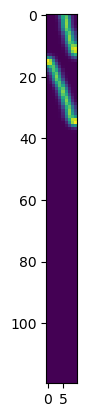

In [20]:
img_bl = cv.GaussianBlur(src=img_ed, ksize=(7, 7), sigmaX=1)
plt.imshow(img_bl)
print(img_bl)

[[ 0  0  0 ... 43  9  1]
 [ 0  0  0 ... 50 11  2]
 [ 0  0  0 ... 59 13  2]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


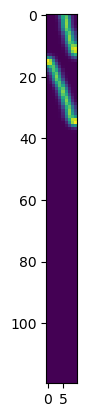

In [33]:
img_line = img_bl.copy()
plt.imshow(img_line)
print(img_line) 

no line detected


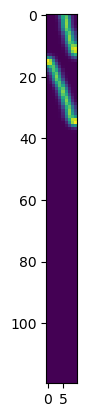

In [36]:
img_line = img_bl.copy()
lines = cv.HoughLinesP(image=img_line, rho=1, theta=np.pi/180, threshold=50, minLineLength=4, maxLineGap=5) #2percent
# lines = cv.HoughLinesP(image=img_line, rho=1, theta=np.pi/180, threshold=25, minLineLength=10, maxLineGap=5) #1prcnt
# lines = cv.HoughLinesP(image=img_line, rho=1, theta=np.pi/180, threshold=25, minLineLength=10, maxLineGap=5) #05prcnt
points = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if 0 <= 180*np.arctan2(abs(y2-y1), abs(x2-x1))/np.pi <= 180:
            points = [x1, y1, x2, y2]
            cv.line(img_line, (x1, y1), (x2, y2), (255, 0, 0), 2)
            break
    angle = 180*np.arctan2(abs(y2-y1), abs(x2-x1))/np.pi
    print(f'slope is: {angle} degrees')
else:
    print("no line detected")
plt.imshow(img_line)
# print(img_line)   